# The file is an analysis of the preliminary $\alpha_{\textrm{CE}}$ variation run following the methods in the tutorial from the compas repo.

In [3]:
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import h5py as h5
import astropy.units as u
import warnings

from matplotlib import rc
from KDEpy import FFTKDE  # Fastest 1D algorithm
from   astropy.cosmology import WMAP9 as cosmology
from scipy import stats
from   scipy.optimize import newton

# Import COMPAS root directory and set data
compasRootDir   = '/Users/adamboesky/Research/PRISE/COMPAS'

# Import COMPAS specific scripts
sys.path.append(compasRootDir + '/utils/CosmicIntegration/')
import ClassCOMPAS, ClassMSSFR, ClassCosmicIntegrator 
import FastCosmicIntegration as FCI 
import selection_effects

# Magic function to set the backend of matplotlib to the 'inline' backend
%matplotlib inline

#Set latex environment for plots/labels
matplotlib.rc('font', **{'family': 'sans-serif'})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_26694/3249585771.py:33: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']


# 1. Create Compas data objects
##  a) Condense the each of the batch's outputs into one h5 file
Function that combines all of the h5 files from each batch. It will write and return the complete h5 file

In [14]:
def condense_h5s(output_dir):

    index = 0 # A useful variable for indexing through the files in the output directory

    # Iterate through the files in the output directory
    for dir in os.listdir(output_dir):
        
        # Make sure that the directories are from the batches
        if dir[0:5] == 'batch':
            batch_num = dir [-1]
            f_h5 = h5.File(output_dir + '/batch_' + batch_num + '/batch_' + batch_num + '.h5', 'r')
            
            # If it's the first batch directory, create an h5 file and copy the first batch's contents into it
            if index == 0:
                # Create an h5 file to put all of the batch's h5 files in
                complete_h5 = h5.File(output_dir + '/complete.h5', 'w')

                # Create and copy the first batch's h5 file into the complete_h5 file
                # DCOs = complete_h5.create_group('BSE_Double_Compact_Objects')
                for group in f_h5.keys():
                    # complete_h5.create_group(group)
                    f_h5.copy(f_h5[group], complete_h5)
                
                DCOs = complete_h5['BSE_Double_Compact_Objects']
                CEs = complete_h5['BSE_Common_Envelopes']
                RLOFs = complete_h5['BSE_RLOF']
                SNs = complete_h5['BSE_Supernovae']
                SPs = complete_h5['BSE_System_Parameters']
                RDs = complete_h5['Run_Details']
                
            # If it's not the first directory, append the new data to each group in the complete h5 file
            else:
                # Append new data to it
                for key in DCOs.keys():
                    DCOs[key].resize((DCOs[key].shape[0] + f_h5['BSE_Double_Compact_Objects'][key].shape[0]), axis=0)
                    DCOs[key][-f_h5['BSE_Double_Compact_Objects'][key].shape[0]:] = f_h5['BSE_Double_Compact_Objects'][key]
                
                for key in CEs.keys():
                    CEs[key].resize((CEs[key].shape[0] + f_h5['BSE_Common_Envelopes'][key].shape[0]), axis=0)
                    CEs[key][-f_h5['BSE_Common_Envelopes'][key].shape[0]:] = f_h5['BSE_Common_Envelopes'][key]
                
                for key in RLOFs.keys():
                    RLOFs[key].resize((RLOFs[key].shape[0] + f_h5['BSE_RLOF'][key].shape[0]), axis=0)
                    RLOFs[key][-f_h5['BSE_RLOF'][key].shape[0]:] = f_h5['BSE_RLOF'][key]
                
                for key in SNs.keys():
                    SNs[key].resize((SNs[key].shape[0] + f_h5['BSE_Supernovae'][key].shape[0]), axis=0)
                    SNs[key][-f_h5['BSE_Supernovae'][key].shape[0]:] = f_h5['BSE_Supernovae'][key]
                
                for key in SPs.keys():
                    SPs[key].resize((SPs[key].shape[0] + f_h5['BSE_System_Parameters'][key].shape[0]), axis=0)
                    SPs[key][-f_h5['BSE_System_Parameters'][key].shape[0]:] = f_h5['BSE_System_Parameters'][key]
                
                for key in RDs.keys():
                    RDs[key].resize((RDs[key].shape[0] + f_h5['Run_Details'][key].shape[0]), axis=0)
                    RDs[key][-f_h5['Run_Details'][key].shape[0]:] = f_h5['Run_Details'][key]

            index+=1 # Update the index
            f_h5.close() # Close the batch file

    complete_h5.close() # Close the complete h5 file
    return output_dir + '/complete.h5'

Condense all .h5 file outputs for the common envelope alpha values

In [15]:
alpha_vals = ['0.1', '0.5', '2.0', '10.0'] # All the alpha values
beta_vals = ['0.25', '0.5', '0.75'] # All the beta values

condensed_paths = {} # 2D dictionary holding the paths to the output h5 files for which the first dimension is the alpha CE value and the second is the beta value

for alpha in alpha_vals:
    condensed_paths[alpha] = {}
    for beta in beta_vals:
        condensed_paths[alpha][beta] = condense_h5s('/Users/adamboesky/Research/PRISE/exploring_parameter_space/Data/output_alpha_CE_beta/alpha_CE_' + alpha + '_beta_' + beta)

*** To use if the h5 files have already been condensed! ***

In [4]:
alpha_vals = ['0.1', '0.5', '2.0', '10.0'] # All the alpha values
beta_vals = ['0.25', '0.5', '0.75'] # All the beta values

condensed_paths = {} # 2D dictionary holding the paths to the output h5 files for which the first dimension is the alpha CE value and the second is the beta value

for alpha in alpha_vals:
    condensed_paths[alpha] = {}
    for beta in beta_vals:
        condensed_paths[alpha][beta] = '/Users/adamboesky/Research/PRISE/exploring_parameter_space/Data/output_alpha_CE_beta/alpha_CE_' + alpha + '_beta_' + beta + '/complete.h5'

## b) Create COMPASData objects for each of the $\alpha_{\textrm{CE}}$ values

In [5]:
# For now, assume all the defaults and just set the paths for each value
data = {} # 2D dictionary in which the first dimension is the alpha CE value and the second is the beta value
for alpha_index, alpha_val in enumerate(alpha_vals):
    data[alpha_val] = {}
    for beta_index, beta_val in enumerate(beta_vals):
        data[alpha_val][beta_val] = ClassCOMPAS.COMPASData(path=condensed_paths[alpha_val][beta_val])


ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid
ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid
ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid
ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid
ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and optionally self.setGridAndMassEvolved() if using a metallicity grid
ClassCOMPAS: Remember to self.setCOMPASDCOmask()
                    then self.setCOMPASData()
          and option

In [34]:
for alpha, beta_dict in data.items():
    for beta, compas_data in beta_dict.items():
        print(compas_data)
        compas_data.Mlower = 5
        compas_data.Mupper = 150
        compas_data.binaryFraction =0.7

        compas_data.setGridAndMassEvolved()

KeyboardInterrupt: 

## c) Check the number of each type of system in the runs

In [36]:
for alpha, beta_dict in data.items():
    for beta, compas_data in beta_dict.items():
        compas_data.setCOMPASDCOmask(types='BBH', pessimistic=True)
        
        #Check if we have any system meeting the criteria
        print('Number of BBH systems at alpha_CE = {alpha} and beta = {beta}'.format(alpha=float(alpha), beta=float(beta)), np.sum(compas_data.DCOmask))

print('')

for alpha, beta_dict in data.items():
    for beta, compas_data in beta_dict.items():
        compas_data.setCOMPASDCOmask(types='BNS', pessimistic=True)
        
        #Check if we have any system meeting the criteria
        print('Number of BNS systems at alpha_CE = {alpha} and beta = {beta}'.format(alpha=float(alpha), beta=float(beta)), np.sum(compas_data.DCOmask))

print('')

for alpha, beta_dict in data.items():
    for beta, compas_data in beta_dict.items():
        compas_data.setCOMPASDCOmask(types='BHNS', pessimistic=True)
        
        #Check if we have any system meeting the criteria
        print('Number of BHNS systems at alpha_CE = {alpha} and beta = {beta}'.format(alpha=float(alpha), beta=float(beta)), np.sum(compas_data.DCOmask))

Number of BBH systems at alpha_CE = 0.1 and beta = 0.25 61805
Number of BBH systems at alpha_CE = 0.1 and beta = 0.5 61020
Number of BBH systems at alpha_CE = 0.1 and beta = 0.75 102579
Number of BBH systems at alpha_CE = 0.5 and beta = 0.25 122996
Number of BBH systems at alpha_CE = 0.5 and beta = 0.5 137105
Number of BBH systems at alpha_CE = 0.5 and beta = 0.75 149897
Number of BBH systems at alpha_CE = 2.0 and beta = 0.25 196674
Number of BBH systems at alpha_CE = 2.0 and beta = 0.5 165740
Number of BBH systems at alpha_CE = 2.0 and beta = 0.75 157426
Number of BBH systems at alpha_CE = 10.0 and beta = 0.25 71813
Number of BBH systems at alpha_CE = 10.0 and beta = 0.5 97340
Number of BBH systems at alpha_CE = 10.0 and beta = 0.75 137663

Number of BNS systems at alpha_CE = 0.1 and beta = 0.25 263
Number of BNS systems at alpha_CE = 0.1 and beta = 0.5 690
Number of BNS systems at alpha_CE = 0.1 and beta = 0.75 1000
Number of BNS systems at alpha_CE = 0.5 and beta = 0.25 105
Number o

In [37]:
for alpha, beta_dict in data.items():
    for beta, compas_data in beta_dict.items():
        compas_data.setCOMPASData()

# 2. Get the detection rates

Import a function that will quickly calculate and return the probability density function (PDF) for a given distribution

## a) NSNS

In [6]:
# First define the parameters

# For what DCO would you like the rate?  options: all, BBH, BHNS BNS
dco_type        = "BNS"
weight_column   = None
                        
merges_hubble_time     = True
pessimistic_CEE        = True
no_RLOF_after_CEE      = True

# Options for the redshift evolution 
max_redshift           = 10.0
max_redshift_detection = 2.0
redshift_step          = 0.001
z_first_SF             = 10

# Metallicity of the Universe
min_logZ               = -12.0 
max_logZ               = 0.0 
step_logZ              = 0.01

#and detector sensitivity
sensitivity            = "O1" 
snr_threshold          = 8 

Mc_max                 = 300.0 
Mc_step                = 0.1 
eta_max                = 0.25 
eta_step               = 0.01
snr_max                = 1000.0 
snr_step               = 0.1

# Parameters to calculate the representing SF mass (make sure these match YOUR simulation!)
m1_min          = 5 * u.Msun 
m1_max          = 150 * u.Msun
m2_min          = 5 * u.Msun
fbin            = 0.7

# Parameters determining dP/dZ and SFR(z), default options from Neijssel 2019
aSF             = 0.01 
bSF             = 2.77 
cSF             = 2.90 
dSF             = 4.70
#
mu0             = 0.035 
muz             = -0.23 
sigma0          = 0.39
sigmaz          = 0. 
alpha           = 0.0 

In [47]:
bns_detection_rates = {}
bns_formation_rates = {}
bns_merger_rates = {}
bns_redshifts = {}
bns_COMPASs = {}

for alpha_index, alpha_ce in enumerate(alpha_vals):
    # Make the dictionary "2D"
    bns_detection_rates[alpha_ce] = {}
    bns_formation_rates[alpha_ce] = {}
    bns_merger_rates[alpha_ce] = {}
    bns_redshifts[alpha_ce] = {}
    bns_COMPASs[alpha_ce] = {}

    for beta_index, beta in enumerate(beta_vals):
        bns_detection_rates[alpha_ce][beta], bns_formation_rates[alpha_ce][beta], bns_merger_rates[alpha_ce][beta], bns_redshifts[alpha_ce][beta], bns_COMPASs[alpha_ce][beta] = \
            FCI.find_detection_rate(
            condensed_paths[alpha_ce][beta], dco_type=dco_type, weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_26122/2544759858.py:17: UserWarning: Maximum chirp mass used for detectability calculation is below maximum binary chirp mass * (1+maximum redshift for detectability calculation)
  FCI.find_detection_rate(


Average_SF_mass_needed =  233014638.7551002 solMass
Average_SF_mass_needed =  235202523.91261742 solMass
Average_SF_mass_needed =  234607382.17072654 solMass
Average_SF_mass_needed =  233438386.66239452 solMass
Average_SF_mass_needed =  236588220.55349916 solMass
Average_SF_mass_needed =  235802813.77703935 solMass
Average_SF_mass_needed =  234661601.2907698 solMass
Average_SF_mass_needed =  234433199.21438885 solMass
Average_SF_mass_needed =  237038210.86425364 solMass
Average_SF_mass_needed =  234304381.99865195 solMass
Average_SF_mass_needed =  234589163.75394046 solMass
Average_SF_mass_needed =  233936239.94600618 solMass


In [48]:
bns_total_formation_rates = {}
bns_total_merger_rates = {}
bns_total_detection_rates = {}
bns_cumulative_detection_rates = {}
bns_detection_rates_by_binary = {}
bns_chirp_masses = {}

for alpha_index, alpha_val in enumerate(alpha_vals):
    # Make the dictionary "2D"
    bns_total_formation_rates[alpha_val] = {}
    bns_total_merger_rates[alpha_val] = {}
    bns_total_detection_rates[alpha_val] = {}
    bns_cumulative_detection_rates[alpha_val] = {}
    bns_detection_rates_by_binary[alpha_val] = {}
    bns_chirp_masses[alpha_val] = {}

    for beta_index, beta_val in enumerate(beta_vals):
        bns_chirp_masses[alpha_val][beta_val] = (bns_COMPASs[alpha_val][beta_val].mass1*bns_COMPASs[alpha_val][beta_val].mass2)**(3./5.) / (bns_COMPASs[alpha_val][beta_val].mass1 + bns_COMPASs[alpha_val][beta_val].mass2)**(1./5.)

        # sum things up across binaries
        bns_total_formation_rates[alpha_val][beta_val] = np.sum(bns_formation_rates[alpha_val][beta_val], axis=0)
        bns_total_merger_rates[alpha_val][beta_val] = np.sum(bns_merger_rates[alpha_val][beta_val], axis=0)
        bns_total_detection_rates[alpha_val][beta_val] = np.sum(bns_detection_rates[alpha_val][beta_val], axis=0)

        # and across redshifts
        bns_cumulative_detection_rates[alpha_val][beta_val] = np.cumsum(bns_total_detection_rates[alpha_val][beta_val])
        bns_detection_rates_by_binary[alpha_val][beta_val] = np.sum(bns_detection_rates[alpha_val][beta_val], axis=1)

In [61]:
maxes = []
mins = []
for alpha_val, beta_dict in bns_chirp_masses.items():
    for beta_val, cms in beta_dict.items():
        # print(cms)
        # print(min(cms))
        maxes.append(max(cms))
        mins.append(min(cms))
print(max(maxes))
print(min(mins))


2.158622591204765
1.0968937097531164


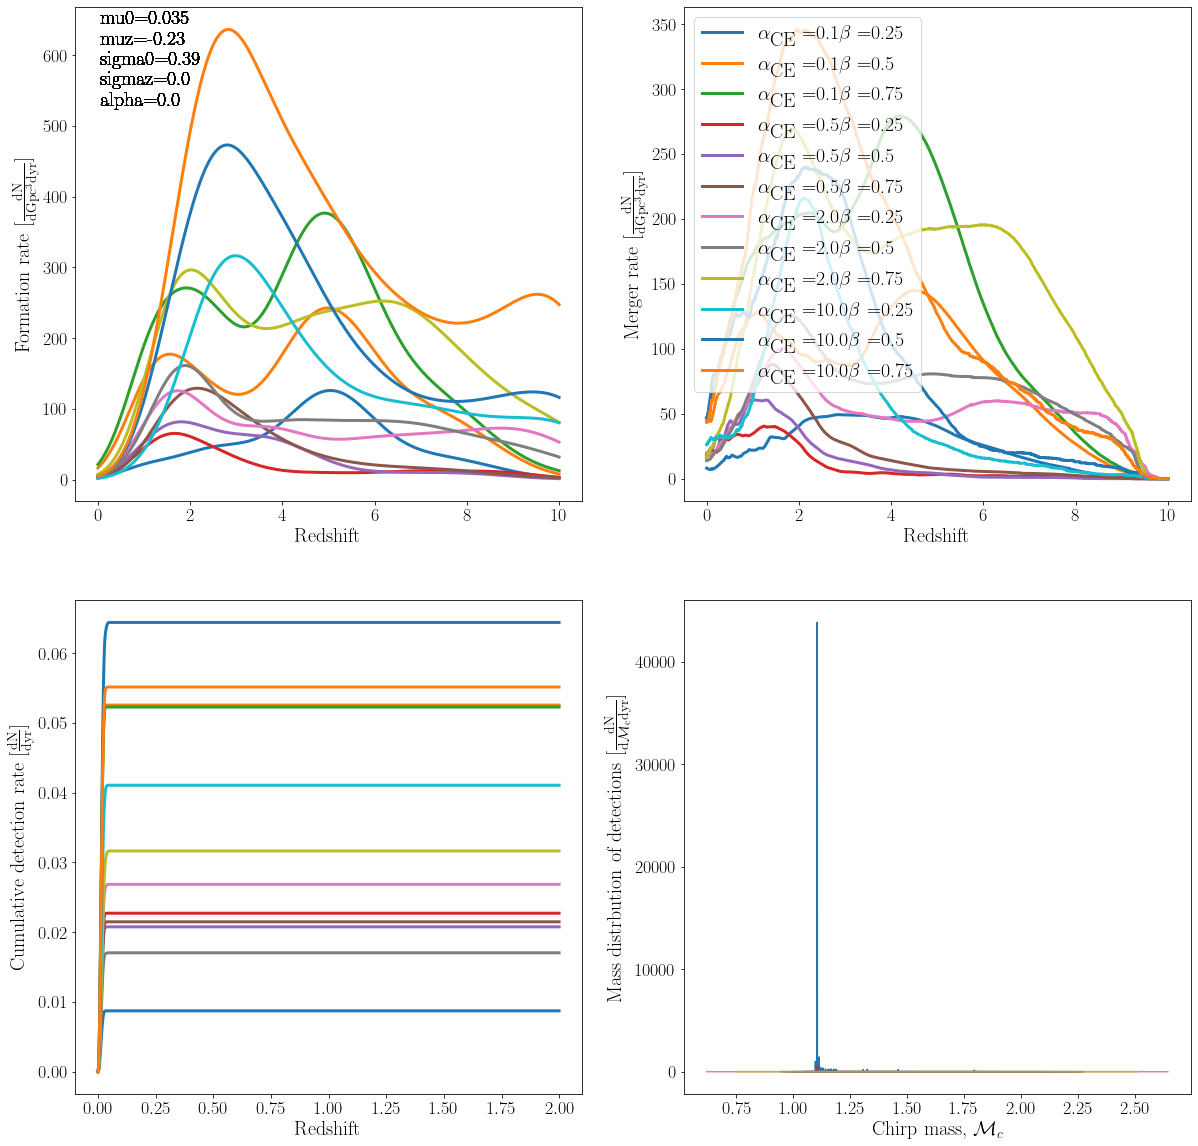

In [68]:
###########################
#Start plotting

# set some constants for the plots
plt.rc('font', family='serif')
fs = 20
lw = 3
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

for alpha_val in alpha_vals:
        for beta_val in beta_vals:

                axes[0,0].plot(bns_redshifts[alpha_val][beta_val], bns_total_formation_rates[alpha_val][beta_val], lw=lw)
                axes[0,0].set_xlabel('Redshift', fontsize=fs)
                axes[0,0].set_ylabel(r'Formation rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

                axes[0,1].plot(bns_redshifts[alpha_val][beta_val], bns_total_merger_rates[alpha_val][beta_val], lw=lw, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)
                axes[0,1].set_xlabel('Redshift', fontsize=fs)
                axes[0,1].set_ylabel(r'Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)
                axes[0,1].legend(loc='upper left', prop={'size': 20})

                axes[1,0].plot(bns_redshifts[alpha_val][beta_val][:len(bns_cumulative_detection_rates[alpha_val][beta_val])], bns_cumulative_detection_rates[alpha_val][beta_val], lw=lw)
                axes[1,0].set_xlabel('Redshift', fontsize=fs)
                axes[1,0].set_ylabel(r'Cumulative detection rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}yr}]$', fontsize=fs)

                bns_axis, bns_mass_kde = FFTKDE(bw='silverman').fit(bns_chirp_masses[alpha_val][beta_val]).evaluate()
                # axes[1,1].hist(chirp_masses[val], weights=detection_rates_by_binary[val], bins=25, range=(min(chirp_masses[val]) - 1, max(chirp_masses[val]) + 1))
                axes[1,1].plot(bns_axis, bns_mass_kde)
                # axes[1,1].set_xlim([1.09, 1.16])        
                axes[1,1].set_xlabel(r'Chirp mass, $\mathcal{M}_c$', fontsize=fs)
                axes[1,1].set_ylabel(r'Mass distrbution of detections $[\rm \frac{\mathrm{d}N}{\mathrm{d}\mathcal{M}_c \mathrm{d}yr}]$', fontsize=fs)

                #########################
                # Plotvalues

                # Add text upper left corner
                axes[0,0].text(0.05,0.8, 
                        "mu0={} \nmuz={} \nsigma0={} \nsigmaz={} \nalpha={}".format(mu0,muz,sigma0,sigmaz,alpha), 
                        transform=axes[0,0].transAxes, size = fs) 

                for ax in axes.flatten():
                        ax.tick_params(labelsize=0.9*fs)
                # Save and show :)
                # plt.savefig(imageDir + "RateInfoHist_mu0{}_muz{}_alpha{}_sigma0{}_sigmaz{}.png".format(mu0, muz, alpha, sigma0, sigmaz), bbox_inches='tight') 

## b) BHNS

In [25]:
dco_type        = "BHNS"

In [27]:
bns_detection_rates = {}
bns_formation_rates = {}
bns_merger_rates = {}
bns_redshifts = {}
bns_COMPASs = {}

for alpha_index, alpha_ce in enumerate(alpha_vals):
    # Make the dictionary "2D"
    bns_detection_rates[alpha_ce] = {}
    bns_formation_rates[alpha_ce] = {}
    bns_merger_rates[alpha_ce] = {}
    bns_redshifts[alpha_ce] = {}
    bns_COMPASs[alpha_ce] = {}

    for beta_index, beta in enumerate(beta_vals):
        bns_detection_rates[alpha_ce][beta], bns_formation_rates[alpha_ce][beta], bns_merger_rates[alpha_ce][beta], bns_redshifts[alpha_ce][beta], bns_COMPASs[alpha_ce][beta] = \
            FCI.find_detection_rate(
            condensed_paths[alpha_ce][beta], dco_type=dco_type, weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_26122/2544759858.py:17: UserWarning: Maximum chirp mass used for detectability calculation is below maximum binary chirp mass * (1+maximum redshift for detectability calculation)
  FCI.find_detection_rate(


Average_SF_mass_needed =  236297345.41788757 solMass
Average_SF_mass_needed =  234370481.91695508 solMass
Average_SF_mass_needed =  235595543.52460238 solMass
Average_SF_mass_needed =  235152677.35844207 solMass
Average_SF_mass_needed =  235535593.30940068 solMass
Average_SF_mass_needed =  235309898.10428107 solMass
Average_SF_mass_needed =  234274672.691901 solMass
Average_SF_mass_needed =  235582174.95977712 solMass
Average_SF_mass_needed =  235197907.3973878 solMass
Average_SF_mass_needed =  234654180.4752139 solMass
Average_SF_mass_needed =  235009231.46978122 solMass
Average_SF_mass_needed =  236244912.97673106 solMass


In [28]:
bns_total_formation_rates = {}
bns_total_merger_rates = {}
bns_total_detection_rates = {}
bns_cumulative_detection_rates = {}
bns_detection_rates_by_binary = {}
bns_chirp_masses = {}

for alpha_index, alpha_val in enumerate(alpha_vals):
    # Make the dictionary "2D"
    bns_total_formation_rates[alpha_val] = {}
    bns_total_merger_rates[alpha_val] = {}
    bns_total_detection_rates[alpha_val] = {}
    bns_cumulative_detection_rates[alpha_val] = {}
    bns_detection_rates_by_binary[alpha_val] = {}
    bns_chirp_masses[alpha_val] = {}

    for beta_index, beta_val in enumerate(beta_vals):
        bns_chirp_masses[alpha_val][beta_val] = (bns_COMPASs[alpha_val][beta_val].mass1*bns_COMPASs[alpha_val][beta_val].mass2)**(3./5.) / (bns_COMPASs[alpha_val][beta_val].mass1 + bns_COMPASs[alpha_val][beta_val].mass2)**(1./5.)

        # sum things up across binaries
        bns_total_formation_rates[alpha_val][beta_val] = np.sum(bns_formation_rates[alpha_val][beta_val], axis=0)
        bns_total_merger_rates[alpha_val][beta_val] = np.sum(bns_merger_rates[alpha_val][beta_val], axis=0)
        bns_total_detection_rates[alpha_val][beta_val] = np.sum(bns_detection_rates[alpha_val][beta_val], axis=0)

        # and across redshifts
        bns_cumulative_detection_rates[alpha_val][beta_val] = np.cumsum(bns_total_detection_rates[alpha_val][beta_val])
        bns_detection_rates_by_binary[alpha_val][beta_val] = np.sum(bns_detection_rates[alpha_val][beta_val], axis=1)

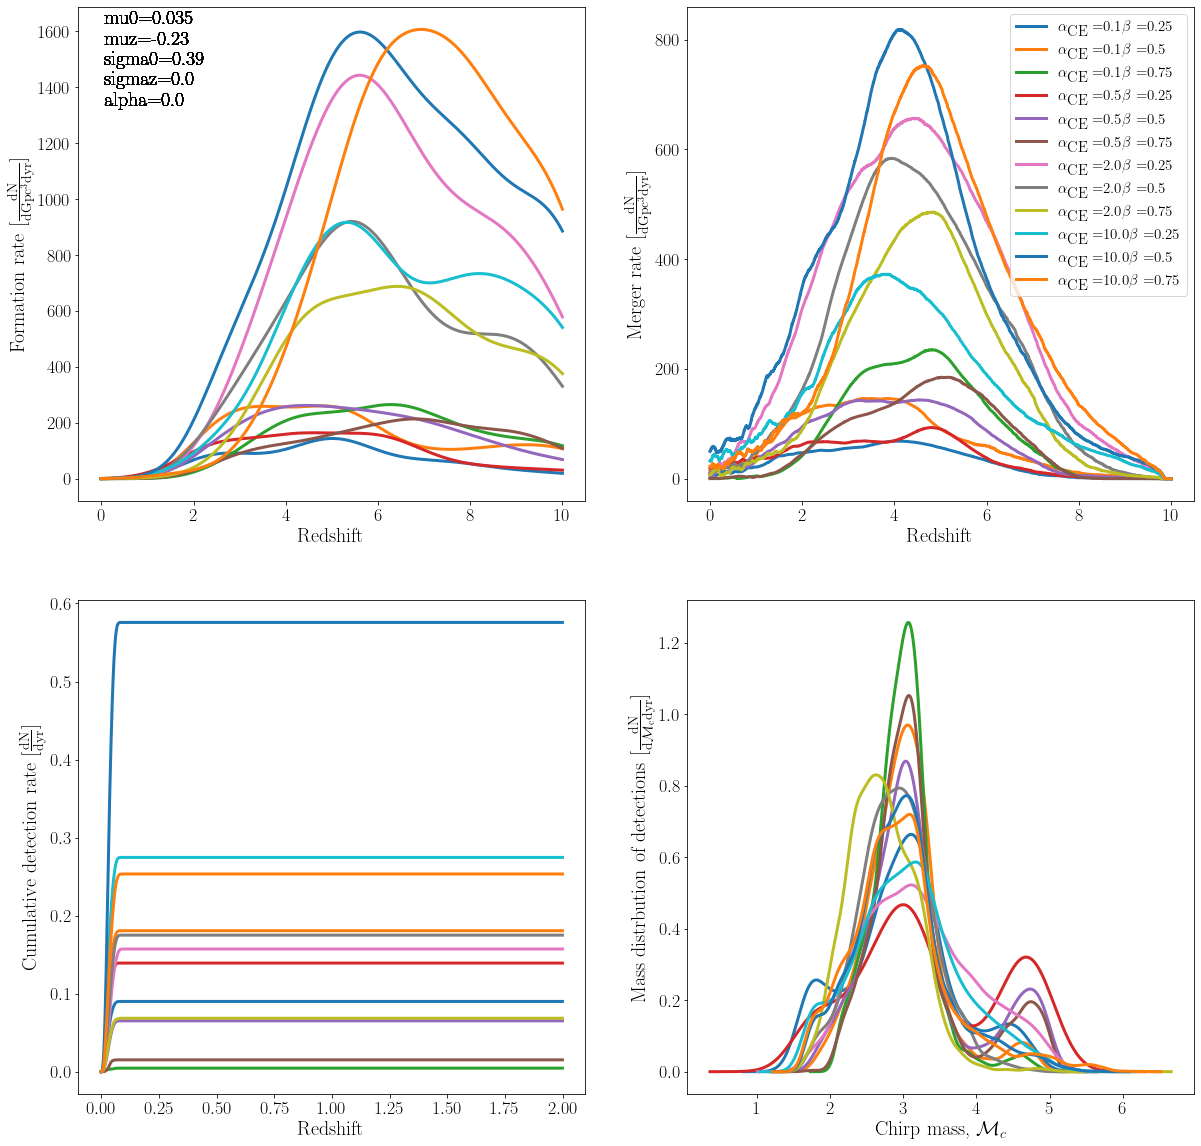

In [31]:
###########################
#Start plotting

# set some constants for the plots
plt.rc('font', family='serif')
fs = 20
lw = 3
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

for alpha_val in alpha_vals:
        for beta_val in beta_vals:

                axes[0,0].plot(bns_redshifts[alpha_val][beta_val], bns_total_formation_rates[alpha_val][beta_val], lw=lw)
                axes[0,0].set_xlabel('Redshift', fontsize=fs)
                axes[0,0].set_ylabel(r'Formation rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

                axes[0,1].plot(bns_redshifts[alpha_val][beta_val], bns_total_merger_rates[alpha_val][beta_val], lw=lw, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)
                axes[0,1].set_xlabel('Redshift', fontsize=fs)
                axes[0,1].set_ylabel(r'Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)
                axes[0,1].legend(loc='upper right', prop={'size': 15})

                axes[1,0].plot(bns_redshifts[alpha_val][beta_val][:len(bns_cumulative_detection_rates[alpha_val][beta_val])], bns_cumulative_detection_rates[alpha_val][beta_val], lw=lw)
                axes[1,0].set_xlabel('Redshift', fontsize=fs)
                axes[1,0].set_ylabel(r'Cumulative detection rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}yr}]$', fontsize=fs)

                bns_axis, bns_mass_kde = FFTKDE(bw='silverman').fit(bns_chirp_masses[alpha_val][beta_val]).evaluate()
                # axes[1,1].hist(chirp_masses[val], weights=detection_rates_by_binary[val], bins=25, range=(min(chirp_masses[val]) - 1, max(chirp_masses[val]) + 1))
                axes[1,1].plot(bns_axis, bns_mass_kde, lw=lw)        
                axes[1,1].set_xlabel(r'Chirp mass, $\mathcal{M}_c$', fontsize=fs)
                axes[1,1].set_ylabel(r'Mass distrbution of detections $[\rm \frac{\mathrm{d}N}{\mathrm{d}\mathcal{M}_c \mathrm{d}yr}]$', fontsize=fs)

                #########################
                # Plotvalues

                # Add text upper left corner
                axes[0,0].text(0.05,0.8, 
                        "mu0={} \nmuz={} \nsigma0={} \nsigmaz={} \nalpha={}".format(mu0,muz,sigma0,sigmaz,alpha), 
                        transform=axes[0,0].transAxes, size = fs) 

                for ax in axes.flatten():
                        ax.tick_params(labelsize=0.9*fs)
                # Save and show :)
                # plt.savefig(imageDir + "RateInfoHist_mu0{}_muz{}_alpha{}_sigma0{}_sigmaz{}.png".format(mu0, muz, alpha, sigma0, sigmaz), bbox_inches='tight') 

## c) BHBH

In [8]:
dco_type        = "BBH"

In [9]:
bns_detection_rates = {}
bns_formation_rates = {}
bns_merger_rates = {}
bns_redshifts = {}
bns_COMPASs = {}

for alpha_index, alpha_ce in enumerate(alpha_vals):
    # Make the dictionary "2D"
    bns_detection_rates[alpha_ce] = {}
    bns_formation_rates[alpha_ce] = {}
    bns_merger_rates[alpha_ce] = {}
    bns_redshifts[alpha_ce] = {}
    bns_COMPASs[alpha_ce] = {}

    for beta_index, beta in enumerate(beta_vals):
        bns_detection_rates[alpha_ce][beta], bns_formation_rates[alpha_ce][beta], bns_merger_rates[alpha_ce][beta], bns_redshifts[alpha_ce][beta], bns_COMPASs[alpha_ce][beta] = \
            FCI.find_detection_rate(
            condensed_paths[alpha_ce][beta], dco_type=dco_type, weight_column=weight_column,
            merges_hubble_time=merges_hubble_time, pessimistic_CEE=pessimistic_CEE,
            no_RLOF_after_CEE=no_RLOF_after_CEE, max_redshift=max_redshift,
            max_redshift_detection=max_redshift_detection,
            redshift_step=redshift_step, z_first_SF=z_first_SF,
            m1_min=m1_min, m1_max=m1_max, m2_min=m2_min,
            fbin=fbin, aSF=aSF, bSF=bSF, cSF=cSF, dSF=dSF,
            mu0=mu0, muz=muz, sigma0=sigma0, alpha=alpha,
            min_logZ=min_logZ, max_logZ=max_logZ, step_logZ=step_logZ,
            sensitivity=sensitivity, snr_threshold=snr_threshold,
            Mc_max=Mc_max, Mc_step=Mc_step,
            eta_max=eta_max, eta_step=eta_step,
            snr_max=snr_max, snr_step=snr_step)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_26694/2544759858.py:17: UserWarning: Maximum chirp mass used for detectability calculation is below maximum binary chirp mass * (1+maximum redshift for detectability calculation)
  FCI.find_detection_rate(


Average_SF_mass_needed =  235286927.44397902 solMass
Average_SF_mass_needed =  234656361.9262687 solMass
Average_SF_mass_needed =  235253414.42953998 solMass
Average_SF_mass_needed =  234847495.8294083 solMass


: 

: 

In [ ]:
bns_total_formation_rates = {}
bns_total_merger_rates = {}
bns_total_detection_rates = {}
bns_cumulative_detection_rates = {}
bns_detection_rates_by_binary = {}
bns_chirp_masses = {}

for alpha_index, alpha_val in enumerate(alpha_vals):
    # Make the dictionary "2D"
    bns_total_formation_rates[alpha_val] = {}
    bns_total_merger_rates[alpha_val] = {}
    bns_total_detection_rates[alpha_val] = {}
    bns_cumulative_detection_rates[alpha_val] = {}
    bns_detection_rates_by_binary[alpha_val] = {}
    bns_chirp_masses[alpha_val] = {}

    for beta_index, beta_val in enumerate(beta_vals):
        bns_chirp_masses[alpha_val][beta_val] = (bns_COMPASs[alpha_val][beta_val].mass1*bns_COMPASs[alpha_val][beta_val].mass2)**(3./5.) / (bns_COMPASs[alpha_val][beta_val].mass1 + bns_COMPASs[alpha_val][beta_val].mass2)**(1./5.)

        # sum things up across binaries
        bns_total_formation_rates[alpha_val][beta_val] = np.sum(bns_formation_rates[alpha_val][beta_val], axis=0)
        bns_total_merger_rates[alpha_val][beta_val] = np.sum(bns_merger_rates[alpha_val][beta_val], axis=0)
        bns_total_detection_rates[alpha_val][beta_val] = np.sum(bns_detection_rates[alpha_val][beta_val], axis=0)

        # and across redshifts
        bns_cumulative_detection_rates[alpha_val][beta_val] = np.cumsum(bns_total_detection_rates[alpha_val][beta_val])
        bns_detection_rates_by_binary[alpha_val][beta_val] = np.sum(bns_detection_rates[alpha_val][beta_val], axis=1)

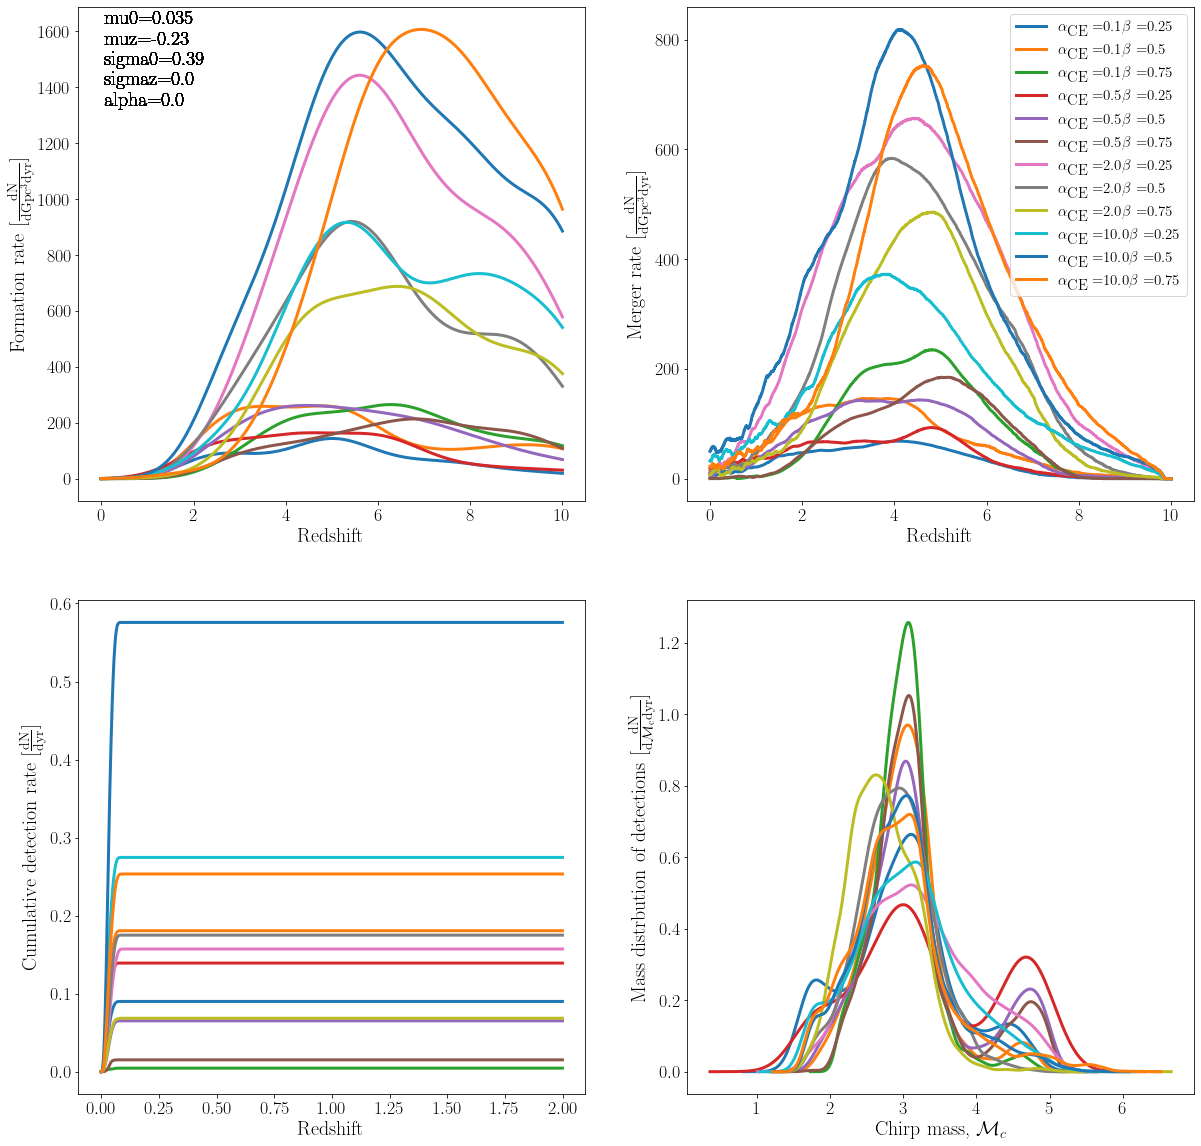

In [ ]:
###########################
#Start plotting

# set some constants for the plots
plt.rc('font', family='serif')
fs = 20
lw = 3
fig, axes = plt.subplots(2, 2, figsize=(20, 20))

for alpha_val in alpha_vals:
        for beta_val in beta_vals:

                axes[0,0].plot(bns_redshifts[alpha_val][beta_val], bns_total_formation_rates[alpha_val][beta_val], lw=lw)
                axes[0,0].set_xlabel('Redshift', fontsize=fs)
                axes[0,0].set_ylabel(r'Formation rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)

                axes[0,1].plot(bns_redshifts[alpha_val][beta_val], bns_total_merger_rates[alpha_val][beta_val], lw=lw, label=r'$\alpha_{\textrm{CE}} = $' + alpha_val + r'$\beta = $' + beta_val)
                axes[0,1].set_xlabel('Redshift', fontsize=fs)
                axes[0,1].set_ylabel(r'Merger rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}Gpc^3 \mathrm{d}yr}]$', fontsize=fs)
                axes[0,1].legend(loc='upper right', prop={'size': 15})

                axes[1,0].plot(bns_redshifts[alpha_val][beta_val][:len(bns_cumulative_detection_rates[alpha_val][beta_val])], bns_cumulative_detection_rates[alpha_val][beta_val], lw=lw)
                axes[1,0].set_xlabel('Redshift', fontsize=fs)
                axes[1,0].set_ylabel(r'Cumulative detection rate $[\rm \frac{\mathrm{d}N}{\mathrm{d}yr}]$', fontsize=fs)

                bns_axis, bns_mass_kde = FFTKDE(bw='silverman').fit(bns_chirp_masses[alpha_val][beta_val]).evaluate()
                # axes[1,1].hist(chirp_masses[val], weights=detection_rates_by_binary[val], bins=25, range=(min(chirp_masses[val]) - 1, max(chirp_masses[val]) + 1))
                axes[1,1].plot(bns_axis, bns_mass_kde, lw=lw)        
                axes[1,1].set_xlabel(r'Chirp mass, $\mathcal{M}_c$', fontsize=fs)
                axes[1,1].set_ylabel(r'Mass distrbution of detections $[\rm \frac{\mathrm{d}N}{\mathrm{d}\mathcal{M}_c \mathrm{d}yr}]$', fontsize=fs)

                #########################
                # Plotvalues

                # Add text upper left corner
                axes[0,0].text(0.05,0.8, 
                        "mu0={} \nmuz={} \nsigma0={} \nsigmaz={} \nalpha={}".format(mu0,muz,sigma0,sigmaz,alpha), 
                        transform=axes[0,0].transAxes, size = fs) 

                for ax in axes.flatten():
                        ax.tick_params(labelsize=0.9*fs)
                # Save and show :)
                # plt.savefig(imageDir + "RateInfoHist_mu0{}_muz{}_alpha{}_sigma0{}_sigmaz{}.png".format(mu0, muz, alpha, sigma0, sigmaz), bbox_inches='tight') 